In [1]:
from casadi import *
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [19]:
def run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, umax=inf, name=None, return_cost=False):
    # Declare model variables
    x1 = MX.sym('x1')
    x2 = MX.sym('x2')
    x3 = MX.sym('x3')
    x = vertcat(x1, x2, x3)
    u = MX.sym('u')

    # Model equations
    xdot = vertcat(-x1/tau_theta, x3, -c*x3-u*x2+(1/tau_theta)*(c-1/tau_theta)*x1)

    # Objective term
    L = (x1+x2)**2+lam*u**2 
    
    # Formulate discrete time dynamics
    if False:
        # CVODES from the SUNDIALS suite
        dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
        opts = {'tf':T/N}
        F = integrator('F', 'cvodes', dae, opts)
    else:
        # Fixed step Runge-Kutta 4 integrator
        M = 4 # RK4 steps per interval
        DT = T/N/M
        f = Function('f', [x, u], [xdot, L])
        X0 = MX.sym('X0', 3)
        U = MX.sym('U')
        X = X0
        Q = 0
        for j in range(M):
            k1, k1_q = f(X, U)
            k2, k2_q = f(X + DT/2 * k1, U)
            k3, k3_q = f(X + DT/2 * k2, U)
            k4, k4_q = f(X + DT * k3, U)
            X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
            Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
        F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])
        
    # Start with an empty NLP
    w = []
    w0 = []
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    # Formulate the NLP
    Xk = MX([init1, init2, init3])
    for k in range(N):
        # New NLP variable for the control
        Uk = MX.sym('U_' + str(k))
        w += [Uk]
        lbw += [-inf]
        ubw += [umax]
        w0 += [0]

        # Integrate till the end of the interval
        Fk = F(x0=Xk, p=Uk)
        Xk = Fk['xf']
        J=J+Fk['qf']

        # Add inequality constraint
        g += [Xk[0]]
        lbg += [-inf]
        ubg += [inf]
        
    # Create an NLP solver
    prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', prob)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x']
    
    if return_cost: return(sol['f'])
    
    # Plot the solution
    u_opt = w_opt
    x_opt = [[init1, init2, init3]]
    for k in range(N):
        Fk = F(x0=x_opt[-1], p=u_opt[k])
        x_opt += [Fk['xf'].full()]
    x1_opt = [r[0] for r in x_opt]
    x2_opt = [r[1] for r in x_opt]
    x3_opt = [r[2] for r in x_opt]

    tgrid = [T/N*k for k in range(N+1)]
    
    plt.figure(1)
    plt.clf()
    plt.plot(tgrid, x1_opt, '--')
    plt.plot(tgrid, x2_opt, '--')
    plt.plot(tgrid, x3_opt, '--')
    plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
    plt.xlabel('t')
    plt.legend(['x1','x2','x3','u'])
    plt.title('cost: {}'.format(sol['f']))
    plt.grid()
    if name: 
        plt.title('cost: {}, {}'.format(sol['f'], name))
        plt.savefig('graphs2/{}.png'.format(name))
    plt.show()
    
    return(sol)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

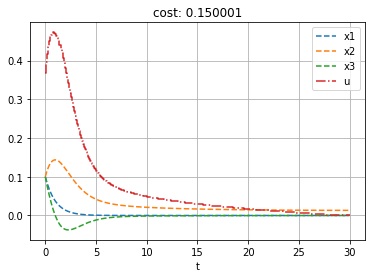

In [18]:
T = 30. # Time horizon
N = 300 # number of control intervals
c = 1
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()
sol = run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3);

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

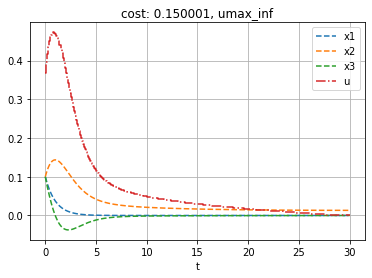

In [20]:
T = 30. # Time horizon
N = 300 # number of control intervals
c = 1
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()
sol = run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, name='umax_inf');

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

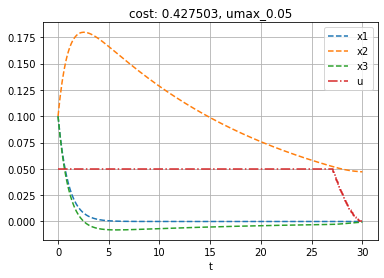

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

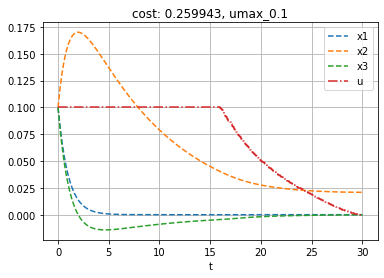

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

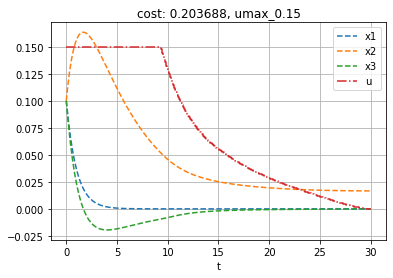

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

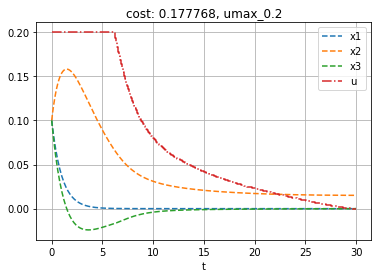

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

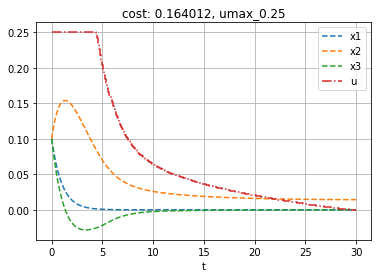

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

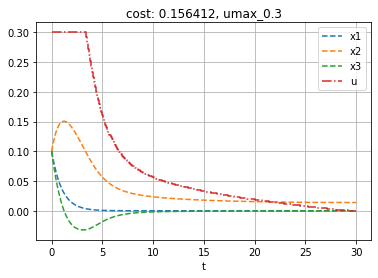

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

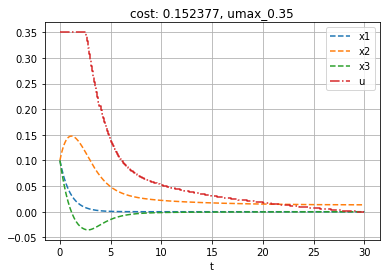

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      300
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

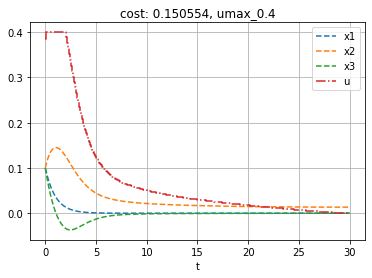

In [25]:
T = 30. # Time horizon
N = 300 # number of control intervals
c = 1
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = .1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()
umaxlst = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for umax in umaxlst:
    sol = run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, umax=umax, name='umax_' + str(umax));

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

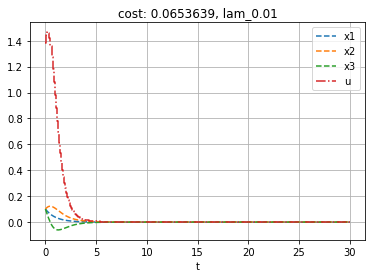

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

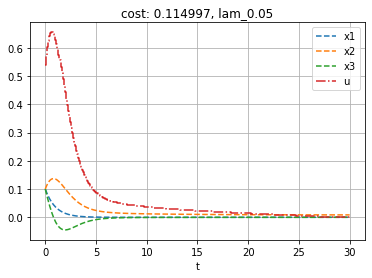

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

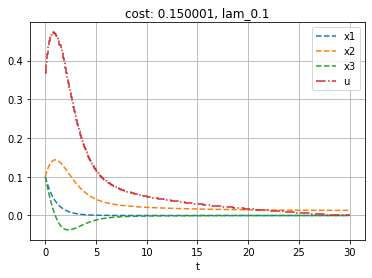

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

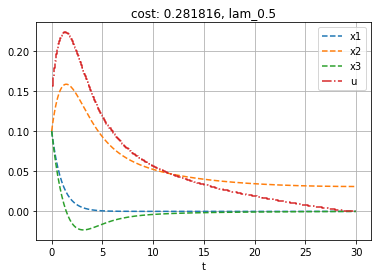

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

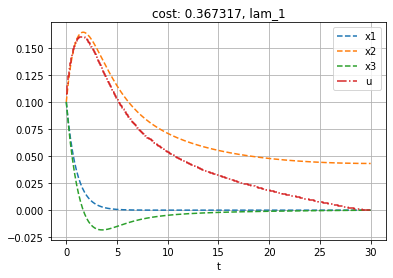

In [26]:
T = 30. # Time horizon
N = 300 # number of control intervals
c = 1
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lamlst = [0.01, 0.05, 0.1, 0.5, 1]
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()

for lam in lamlst:
    sol = run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, name='lam_' + str(lam));

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

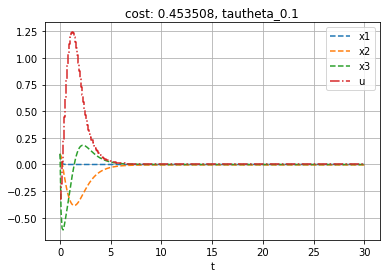

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

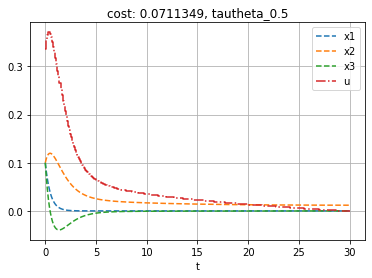

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

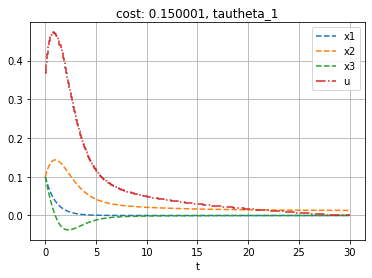

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

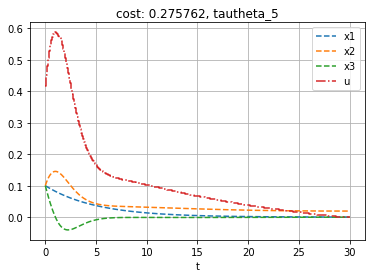

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

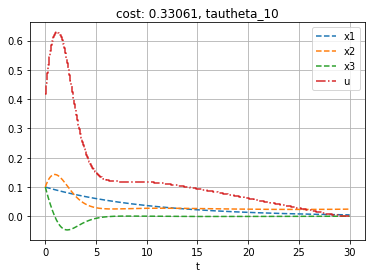

In [27]:
T = 30. # Time horizon
N = 300 # number of control intervals
c = 1
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = 0.1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()
tau_thetalst = [0.1, 0.5, 1, 5, 10]

for tau_theta in tau_thetalst:
    run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, name='tautheta_' + str(tau_theta));

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

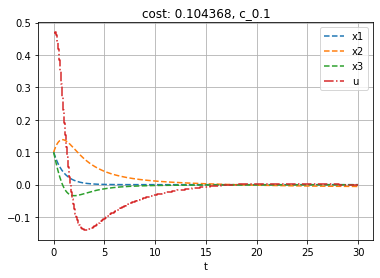

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

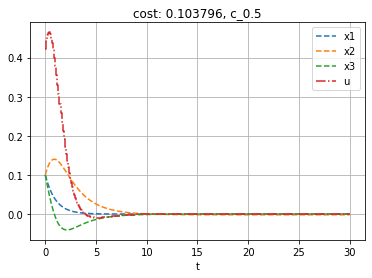

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

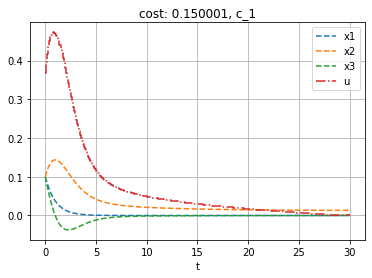

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

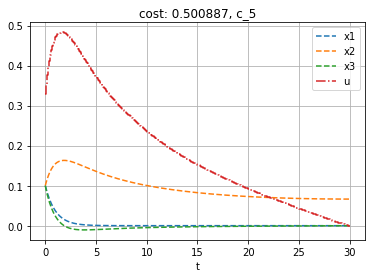

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    45150

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

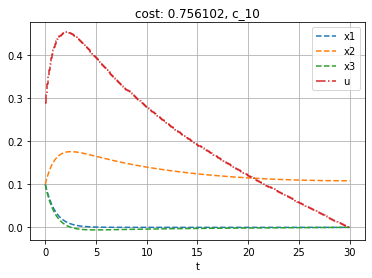

In [28]:
T = 30. # Time horizon
N = 300 # number of control intervals
clst = [0.1, 0.5, 1, 5, 10]
tau_theta = 1 #10*np.random.uniform()
tau_phi = 1 #10*np.random.uniform()
lam = 0.1
init1 = 0.1 #np.pi/20*np.random.normal()
init2 = 0.1 #np.pi/20*np.random.normal()
init3 = 0.1 #np.pi/20*np.random.normal()

for c in clst:
    run_model(T, N, c, tau_theta, tau_phi, lam, init1, init2, init3, name='c_' + str(c));